# Importing libraries

In [1]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from keras.optimizers import RMSprop
import numpy as np
import random
import sys

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Loading Dataset

In [3]:
#LOAD TEXT
#Save notepad as UTF-8 (select from dropdown during saving)
filename = "/content/drive/MyDrive/College Study/6th Sem/Deep Learning/Practical 9/jungle_book.txt"
raw_text = open(filename, 'r', encoding='utf-8').read()
raw_text = raw_text.lower()
print(raw_text[0:1000])

﻿the project gutenberg ebook of the jungle book, by rudyard kipling

this ebook is for the use of anyone anywhere in the united states and
most other parts of the world at no cost and with almost no restrictions
whatsoever. you may copy it, give it away or re-use it under the terms
of the project gutenberg license included with this ebook or online at
www.gutenberg.org. if you are not located in the united states, you
will have to check the laws of the country where you are located before
using this ebook.

title: the jungle book

author: rudyard kipling

illustrator: m. & e. detmold

release date: march, 1995 [ebook #236]
[most recently updated: may 1, 2023]

language: english


*** start of the project gutenberg ebook the jungle book ***




the jungle book

by rudyard kipling



contents

     mowgli’s brothers
     hunting-song of the seeonee pack
     kaa’s hunting
     road-song of the bandar-log
     “tiger! tiger!”
      mowgli’s song
     the white seal
     lukannon
     “rik

# Cleaning Text

In [4]:
#CLEAN TEXT
#Remove numbers
raw_text = ''.join(c for c in raw_text if not c.isdigit())

#How many total characters do we have in our training text?
chars = sorted(list(set(raw_text))) #List of every character



In [5]:
print(len(chars))

56


In [6]:
print(chars)

['\n', ' ', '!', '#', '$', '%', '&', "'", '(', ')', '*', ',', '-', '.', '/', ':', ';', '?', '[', ']', '_', '`', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'â', '—', '’', '“', '”', '•', '™', '\ufeff']


# Creating dictionary for unique sequences

In [7]:
#Character sequences must be encoded as integers.
#Each unique character will be assigned an integer value.
#Create a dictionary of characters mapped to integer values
char_to_int = dict((c, i) for i, c in enumerate(chars))

#Do the reverse so we can print our predictions in characters and not integers
int_to_char = dict((i, c) for i, c in enumerate(chars))

In [8]:
print(char_to_int)

{'\n': 0, ' ': 1, '!': 2, '#': 3, '$': 4, '%': 5, '&': 6, "'": 7, '(': 8, ')': 9, '*': 10, ',': 11, '-': 12, '.': 13, '/': 14, ':': 15, ';': 16, '?': 17, '[': 18, ']': 19, '_': 20, '`': 21, 'a': 22, 'b': 23, 'c': 24, 'd': 25, 'e': 26, 'f': 27, 'g': 28, 'h': 29, 'i': 30, 'j': 31, 'k': 32, 'l': 33, 'm': 34, 'n': 35, 'o': 36, 'p': 37, 'q': 38, 'r': 39, 's': 40, 't': 41, 'u': 42, 'v': 43, 'w': 44, 'x': 45, 'y': 46, 'z': 47, 'â': 48, '—': 49, '’': 50, '“': 51, '”': 52, '•': 53, '™': 54, '\ufeff': 55}


In [9]:
print(int_to_char)

{0: '\n', 1: ' ', 2: '!', 3: '#', 4: '$', 5: '%', 6: '&', 7: "'", 8: '(', 9: ')', 10: '*', 11: ',', 12: '-', 13: '.', 14: '/', 15: ':', 16: ';', 17: '?', 18: '[', 19: ']', 20: '_', 21: '`', 22: 'a', 23: 'b', 24: 'c', 25: 'd', 26: 'e', 27: 'f', 28: 'g', 29: 'h', 30: 'i', 31: 'j', 32: 'k', 33: 'l', 34: 'm', 35: 'n', 36: 'o', 37: 'p', 38: 'q', 39: 'r', 40: 's', 41: 't', 42: 'u', 43: 'v', 44: 'w', 45: 'x', 46: 'y', 47: 'z', 48: 'â', 49: '—', 50: '’', 51: '“', 52: '”', 53: '•', 54: '™', 55: '\ufeff'}


# Summarizing the data

In [10]:
n_chars = len(raw_text)
n_vocab = len(chars)
print("Total Characters in the text; corpus length: ", n_chars)
print("Total Vocab: ", n_vocab)

Total Characters in the text; corpus length:  291930
Total Vocab:  56


# Creating Sequences

In [11]:
########################
#Now that we have characters we can create input/output sequences for training
#Remember that for LSTM input and output can be sequences... hence the term seq2seq
seq_length = 60  #Length of each input sequence
step = 10   #Instead of moving 1 letter at a time, try skipping a few.
sentences = []    # X values (Sentences)
next_chars = []   # Y values. The character that follows the sentence defined as X
for i in range(0, n_chars - seq_length, step):  #step=1 means each sentence is offset just by a single letter
    sentences.append(raw_text[i: i + seq_length])  #Sequence in
    next_chars.append(raw_text[i + seq_length])  #Sequence out
n_patterns = len(sentences)
print('Number of sequences:', n_patterns)


Number of sequences: 29187


In [12]:
print("x is",sentences[2])
print("y is",next_chars[2])

x is rg ebook of the jungle book, by rudyard kipling

this ebook 
y is i


In [13]:
#Just like time series, X is the sequence / sentence and y is the next value
#that comes after the sentence...

# reshape input to be [samples, time steps, features]

#time steps = sequence length
#features = numbers of characters in our vocab (n_vocab)
#Vectorize all sentences: there are n_patterns sentences.
#For each sentence we have n_vocab characters available for seq_length
#Vectorization returns a vector for all sentences indicating the presence or absence
#of a character.

x = np.zeros((len(sentences), seq_length, n_vocab), dtype=bool)
y = np.zeros((len(sentences), n_vocab), dtype=bool)
for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        x[i, t, char_to_int[char]] = 1
    y[i, char_to_int[next_chars[i]]] = 1

print(x.shape)
print(y.shape)

#print(x[0].shape)
#print(y[0].shape)

(29187, 60, 56)
(29187, 56)


# Model building

In [14]:
##################################################
#Basic model with one LSTM
# build the model: a single LSTM

model = Sequential()
model.add(LSTM(128, input_shape=(seq_length, n_vocab), return_sequences=True))
model.add(LSTM(64, return_sequences=True))
model.add(LSTM(32))
model.add(Dense(n_vocab, activation='softmax'))

optimizer = RMSprop(lr=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 128)           94720     
                                                                 
 lstm_1 (LSTM)               (None, 60, 64)            49408     
                                                                 
 lstm_2 (LSTM)               (None, 32)                12416     
                                                                 
 dense (Dense)               (None, 56)                1848      
                                                                 
Total params: 158392 (618.72 KB)
Trainable params: 158392 (618.72 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


# Training and saving the model

Epoch 1/100
229/229 [==============================] - 3s 12ms/step - loss: 2.7405
Epoch 2/100
229/229 [==============================] - 3s 11ms/step - loss: 2.6853
Epoch 3/100
229/229 [==============================] - 3s 13ms/step - loss: 2.6028
Epoch 4/100
229/229 [==============================] - 3s 14ms/step - loss: 2.5128
Epoch 5/100
229/229 [==============================] - 3s 12ms/step - loss: 2.4579
Epoch 6/100
229/229 [==============================] - 3s 11ms/step - loss: 2.4127
Epoch 7/100
229/229 [==============================] - 2s 11ms/step - loss: 2.3734
Epoch 8/100
229/229 [==============================] - 2s 11ms/step - loss: 2.3341
Epoch 9/100
229/229 [==============================] - 3s 14ms/step - loss: 2.3015
Epoch 10/100
229/229 [==============================] - 3s 15ms/step - loss: 2.2747
Epoch 11/100
229/229 [==============================] - 3s 11ms/step - loss: 2.2489
Epoch 12/100
229/229 [==============================] - 2s 11ms/step - loss: 2.2276
E

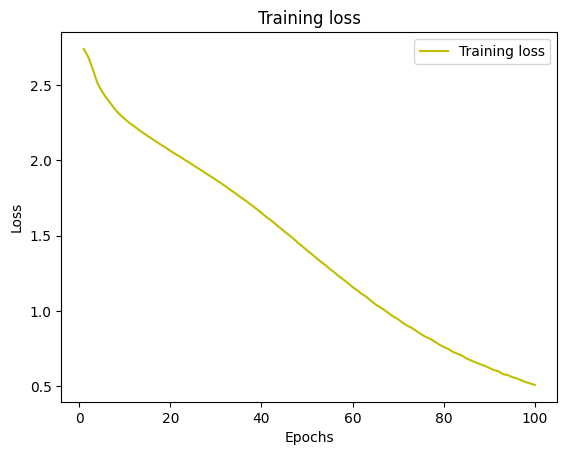

In [16]:
# define the checkpoint
from keras.callbacks import ModelCheckpoint

# filepath="saved_weights/saved_weights-{epoch:02d}-{loss:.4f}.hdf5"
# checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')

# callbacks_list = [checkpoint]


# Fit the model

history = model.fit(x, y,
          batch_size=128,
          epochs=100,
          # callbacks=callbacks_list)
)

# model.save('my_saved_weights_jungle_book_50epochs.h5')
##########################################################################

from matplotlib import pyplot as plt
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


# Generating Characters

In [17]:
#Generate characters
#We must provide a sequence of seq_lenth as input to start the generation process

#The prediction results is probabilities for each of the 48 characters at a specific
#point in sequence. Let us pick the one with max probability and print it out.
#Writing our own softmax function....

def sample(preds):
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds)
    exp_preds = np.exp(preds) #exp of log (x), isn't this same as x??
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)


In [18]:
#Prediction
# load the network weights
filename = "my_saved_weights_jungle_book_50epochs.h5"
# model.load_weights(filename)

#Pick a random sentence from the text as seed.
start_index = random.randint(0, n_chars - seq_length - 1)

#Initiate generated text and keep adding new predictions and print them out
generated = ''
sentence = raw_text[start_index: start_index + seq_length]
generated += sentence

print('----- Seed for our text prediction: "' + sentence + '"')
#sys.stdout.write(generated)


for i in range(400):   # Number of characters including spaces
    x_pred = np.zeros((1, seq_length, n_vocab))
    for t, char in enumerate(sentence):
        x_pred[0, t, char_to_int[char]] = 1.

    preds = model.predict(x_pred, verbose=0)[0]
    next_index = sample(preds)
    next_char = int_to_char[next_index]

    generated += next_char
    sentence = sentence[1:] + next_char

    sys.stdout.write(next_char)
    sys.stdout.flush()
print()


----- Seed for our text prediction: "nd waving their flippers like the frog footman. when they be"
 lencelent deopnd whitirl bey loutd like.
stit’ dicks and eofna have sal nottgle as the picks fol rikk.
stike, but welu blowner. man! as
it men the was they coufging him anys to mast and swowk in to shat a dcopting he was leaged to sat in the wall, of the battee beand cable
sall sed harla! “nere flerw. with toung ans revey mone to himey baloust. ne
kand bumfily and shoffiwsss. “ilegtore king abut 
